In [20]:
import numpy as np #linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# dataset = pd.read_csv("./data/emotion.data")
dataset = pd.read_csv("data/emotion.data", engine='python')
dataset

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


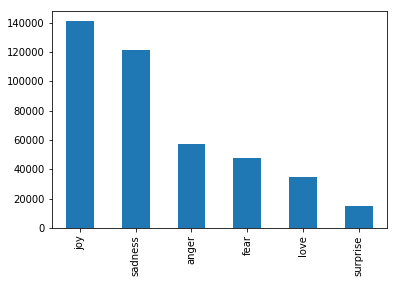

In [2]:
%matplotlib inline
dataset.emotions.value_counts().plot.bar()

In [3]:
dataset.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


In [4]:
# Tokenization

input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
# input_sentences
labels = dataset["emotions"].values.tolist()

In [5]:
# Creating Vocabulary (word index)

word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
                word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)

# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}

label2id

{'fear': 0, 'sadness': 1, 'surprise': 2, 'joy': 3, 'love': 4, 'anger': 5}

In [6]:
# Encoding samples with corresponding integer values

import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Using TensorFlow backend.


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [7]:
# Build LSTM model with attention

embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs = keras.layers.Embedding(len(word2id)+1, embedding_dim, input_length=max_words)(sequence_input)
# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(keras.layers.LSTM(embedding_dim, return_sequences=True))(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism = Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [9]:
# Train model 10 iterations
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

model.save('my_model_0221.h5')  # creates a HDF5 file 'my_model.h5'

Train on 375128 samples, validate on 41681 samples
Epoch 1/2
375128/375128 [==============================] - 3444s 9ms/step - loss: 0.2014 - acc: 0.9019 - val_loss: 0.0931 - val_acc: 0.9384
Epoch 2/2
375128/375128 [==============================] - 3414s 9ms/step - loss: 0.0903 - acc: 0.9416 - val_loss: 0.0908 - val_acc: 0.9401


In [10]:
import keras
from keras.models import load_model

model = load_model('my_model_0221.h5')

# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,outputs=[model.output,model.get_layer('attention_vec').output])

In [23]:
import random
import math

#max_words = 178

# Select random samples to illustrate
#sample_text = random.choice(dataset["text"].values.tolist())

test = "i am feeling completely overwhelmed today"
sample_text = test

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

print(encoded_samples)

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

print(encoded_samples)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)

print(attentions)
print(label_probs)

label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}
print(label_probs)

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)
    
print(token_attention_dic)

[[0, 56, 48, 706, 425, 346]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0  56  48 706 425 346]]
[[1.72495538e-06 9.63312459e-07 6.32687318e-07 4.54832247e-07
  3.81283684e-07 3.55522275e-07 3.47694566e-07 3.45670827e-07
  3.45258997e-07 3.45181633e-07 3.45094094e-07 3.44936808e-07
  3.44722707e-07 3.44478195e-07 3.44223707e-07 3.43

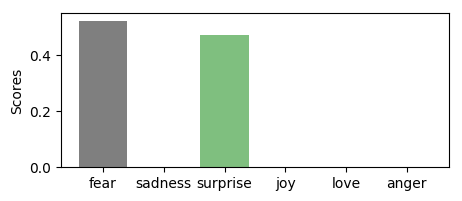

In [24]:
# VISUALIZATION

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'>    <b>Text: </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} </span> ".format(attention2color(attention), token)
html_text += "</p>"

# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]

plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()